<a href="https://colab.research.google.com/github/omkarade/A-to-Z-Approach-on-Time-Series-And-Forecasting./blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**downloading data**

In [ ]:
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c store-sales-time-series-forecasting
! unzip store-sales-time-series-forecasting.zip

 42% 9.00M/21.4M [00:01<00:02, 6.43MB/s]
100% 21.4M/21.4M [00:01<00:00, 16.5MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [ ]:
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_squared_error
import pylab 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from joblib import Parallel, delayed
import joblib
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

**Data loading**

In [ ]:
tran=pd.read_csv('train.csv')
stores=pd.read_csv('stores.csv')
transactions=pd.read_csv('transactions.csv')
oil=pd.read_csv('oil.csv')
holidays_events=pd.read_csv('holidays_events.csv')
data1 = tran.merge(stores, how = 'left', on = 'store_nbr' )
data1['date'] = pd.to_datetime(data1['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])
data2 = data1.merge(holidays_events, how = 'left', on = 'date' )
data2 = data2.merge(oil, how ='left', on ='date')
data2["type_y"] = data2["type_y"].fillna("Not Holiday")
data2["locale"] = data2["locale"].fillna("Not Holiday")
data2["locale_name"] = data2["locale_name"].fillna("Ecuador")
data2["description"] = data2["description"].fillna("NA")
data2["transferred"] = data2["transferred"].fillna(False)
data2["dcoilwtico"] = data2["dcoilwtico"].fillna(np.mean(data2["dcoilwtico"]))
data2["description"] = data2["description"].fillna("NA")
data2["month"] = data2['date'].map(lambda x: x.month)

**In EDA got some unnecessary columns so Removing them**

In [ ]:
data2=data2.drop(columns="dcoilwtico")
data2=data2.drop(columns="id")
data2=data2.drop(columns="transferred")

In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]

**Function_1-Pipline for clening to predicting**

In [ ]:
def clen_to_pred(data2,fulldata,model=""):
#training RandomForestRegressor Model
  if model=="RandomForestRegressor":
    descp=pd.concat([data2,fulldata], ignore_index=True, axis=0)
    descp=descp.drop(columns="date")
    catage=descp[["family","city","state","type_x","type_y","locale","locale_name","description"]]
    #Converting Categorical Features Into One Hot Encoding  
    descr=pd.get_dummies(catage)
    descr["store_nbr"]=descp["store_nbr"]
    descr["onpromotion"]=descp["onpromotion"]
    descr["cluster"]=descp["cluster"]

    #Adding lag Features
    train=descr[:22000]
    train["sales"]=fulldata["sales"]
    train['sales_lag_15'] = train['sales'].shift(2)
    train['sales_lag_30'] = train['sales'].shift(3)
    train['sales_lag_60'] = train['sales'].shift(7)
    train['sales_lag_140'] = train['sales'].shift(15)
    train['sales_lag_15'] = train['sales_lag_15'].fillna(0)
    train['sales_lag_30'] = train['sales_lag_30'].fillna(0)
    train['sales_lag_60'] = train['sales_lag_60'].fillna(0)
    train['sales_lag_140'] = train['sales_lag_140'].fillna(0)
    train['Expo_moving_sale_2']=train['sales'].ewm(com=0.2).mean()
    train['Expo_moving_sale_4']=train['sales'].ewm(com=0.4).mean()
    train['Expo_moving_sale_6']=train['sales'].ewm(com=0.6).mean()
    train['Expo_moving_sale_8']=train['sales'].ewm(com=0.8).mean()
    
    #Adding lag Features into test data
    testa=descr[22000:]
    testa["sales"]=data2["sales"]
    testa['sales_lag_15'] = testa['sales'].shift(2)
    testa['sales_lag_30'] = testa['sales'].shift(3)
    testa['sales_lag_60'] = testa['sales'].shift(7)
    testa['sales_lag_140'] = testa['sales'].shift(15)
    testa['sales_lag_15'] = testa['sales_lag_15'].fillna(0)
    testa['sales_lag_30'] = testa['sales_lag_30'].fillna(0)
    testa['sales_lag_60'] = testa['sales_lag_60'].fillna(0)
    testa['sales_lag_140'] = testa['sales_lag_140'].fillna(0)
    testa['Expo_moving_sale_2']=testa['sales'].ewm(com=0.2).mean()
    testa['Expo_moving_sale_4']=testa['sales'].ewm(com=0.4).mean()
    testa['Expo_moving_sale_6']=testa['sales'].ewm(com=0.6).mean()
    testa['Expo_moving_sale_8']=testa['sales'].ewm(com=0.8).mean()

    testa=testa.drop(columns="sales")
    y_main=fulldata.sales
    train=train.drop(columns="sales")
    train=train.fillna(0)
    train1=train[:22000]

    #Training RandomForestRegressor 
    regr = RandomForestRegressor(n_estimators=1100)
    regr.fit(train1,y_main)
    y_main2=data2.sales
    testa=testa.fillna(0)
    #Predicting Test Data 
    Y_predict=regr.predict(testa)
    return Y_predict,y_main2

  if model=="LinearRegression":
    descp=pd.concat([data2,fulldata], ignore_index=True, axis=0)
    descp=descp.drop(columns="date")
    catage=descp[["family","city","state","type_x","type_y","locale","locale_name","description"]]
    #Converting Categorical Features Into One Hot Encoding  
    descr=pd.get_dummies(catage)
    descr["store_nbr"]=descp["store_nbr"]
    descr["onpromotion"]=descp["onpromotion"]
    descr["cluster"]=descp["cluster"]

    #Adding lag Features
    train=descr[:22000]
    train["sales"]=fulldata["sales"]
    train['sales_lag_15'] = train['sales'].shift(2)
    train['sales_lag_30'] = train['sales'].shift(3)
    train['sales_lag_60'] = train['sales'].shift(7)
    train['sales_lag_140'] = train['sales'].shift(15)
    train['sales_lag_15'] = train['sales_lag_15'].fillna(0)
    train['sales_lag_30'] = train['sales_lag_30'].fillna(0)
    train['sales_lag_60'] = train['sales_lag_60'].fillna(0)
    train['sales_lag_140'] = train['sales_lag_140'].fillna(0)
    train['Expo_moving_sale_2']=train['sales'].ewm(com=0.2).mean()
    train['Expo_moving_sale_4']=train['sales'].ewm(com=0.4).mean()
    train['Expo_moving_sale_6']=train['sales'].ewm(com=0.6).mean()
    train['Expo_moving_sale_8']=train['sales'].ewm(com=0.8).mean()
    
    #Adding lag Features into test data
    testa=descr[22000:]
    testa["sales"]=data2["sales"]
    testa['sales_lag_15'] = testa['sales'].shift(2)
    testa['sales_lag_30'] = testa['sales'].shift(3)
    testa['sales_lag_60'] = testa['sales'].shift(7)
    testa['sales_lag_140'] = testa['sales'].shift(15)
    testa['sales_lag_15'] = testa['sales_lag_15'].fillna(0)
    testa['sales_lag_30'] = testa['sales_lag_30'].fillna(0)
    testa['sales_lag_60'] = testa['sales_lag_60'].fillna(0)
    testa['sales_lag_140'] = testa['sales_lag_140'].fillna(0)
    testa['Expo_moving_sale_2']=testa['sales'].ewm(com=0.2).mean()
    testa['Expo_moving_sale_4']=testa['sales'].ewm(com=0.4).mean()
    testa['Expo_moving_sale_6']=testa['sales'].ewm(com=0.6).mean()
    testa['Expo_moving_sale_8']=testa['sales'].ewm(com=0.8).mean()

    testa=testa.drop(columns="sales")
    y_main=fulldata.sales
    train=train.drop(columns="sales")
    train=train.fillna(0)
    train1=train[:22000]

    regr=LinearRegression()
    regr.fit(train1,y_main)
    y_main2=data2.sales
    testa=testa.fillna(0)
    #Predicting Test Data 
    Y_predict=regr.predict(testa)
    return Y_predict,y_main2


  if model=="SVM":
    descp=pd.concat([data2,fulldata], ignore_index=True, axis=0)
    descp=descp.drop(columns="date")
    catage=descp[["family","city","state","type_x","type_y","locale","locale_name","description"]]
    #Converting Categorical Features Into One Hot Encoding  
    descr=pd.get_dummies(catage)
    descr["store_nbr"]=descp["store_nbr"]
    descr["onpromotion"]=descp["onpromotion"]
    descr["cluster"]=descp["cluster"]

    #Adding lag Features
    train=descr[:22000]
    train["sales"]=fulldata["sales"]
    train['sales_lag_15'] = train['sales'].shift(2)
    train['sales_lag_30'] = train['sales'].shift(3)
    train['sales_lag_60'] = train['sales'].shift(7)
    train['sales_lag_140'] = train['sales'].shift(15)
    train['sales_lag_15'] = train['sales_lag_15'].fillna(0)
    train['sales_lag_30'] = train['sales_lag_30'].fillna(0)
    train['sales_lag_60'] = train['sales_lag_60'].fillna(0)
    train['sales_lag_140'] = train['sales_lag_140'].fillna(0)
    train['Expo_moving_sale_2']=train['sales'].ewm(com=0.2).mean()
    train['Expo_moving_sale_4']=train['sales'].ewm(com=0.4).mean()
    train['Expo_moving_sale_6']=train['sales'].ewm(com=0.6).mean()
    train['Expo_moving_sale_8']=train['sales'].ewm(com=0.8).mean()
    
    #Adding lag Features into test data
    testa=descr[22000:]
    testa["sales"]=data2["sales"]
    testa['sales_lag_15'] = testa['sales'].shift(2)
    testa['sales_lag_30'] = testa['sales'].shift(3)
    testa['sales_lag_60'] = testa['sales'].shift(7)
    testa['sales_lag_140'] = testa['sales'].shift(15)
    testa['sales_lag_15'] = testa['sales_lag_15'].fillna(0)
    testa['sales_lag_30'] = testa['sales_lag_30'].fillna(0)
    testa['sales_lag_60'] = testa['sales_lag_60'].fillna(0)
    testa['sales_lag_140'] = testa['sales_lag_140'].fillna(0)
    testa['Expo_moving_sale_2']=testa['sales'].ewm(com=0.2).mean()
    testa['Expo_moving_sale_4']=testa['sales'].ewm(com=0.4).mean()
    testa['Expo_moving_sale_6']=testa['sales'].ewm(com=0.6).mean()
    testa['Expo_moving_sale_8']=testa['sales'].ewm(com=0.8).mean()

    testa=testa.drop(columns="sales")
    y_main=fulldata.sales
    train=train.drop(columns="sales")
    train=train.fillna(0)
    train1=train[:22000]

    regressor = SVR(C=10, epsilon=0.5, gamma=1e-07, kernel='rbf')
    regressor.fit(train1,y_main)
    y_main2=data2.sales
    testa=testa.fillna(0)
    #Predicting Test Data 
    Y_predict=regressor.predict(testa)
    return Y_predict,y_main2

  if model=="DecisionTreeRegressor":
    descp=pd.concat([data2,fulldata], ignore_index=True, axis=0)
    descp=descp.drop(columns="date")
    catage=descp[["family","city","state","type_x","type_y","locale","locale_name","description"]]
    #Converting Categorical Features Into One Hot Encoding  
    descr=pd.get_dummies(catage)
    descr["store_nbr"]=descp["store_nbr"]
    descr["onpromotion"]=descp["onpromotion"]
    descr["cluster"]=descp["cluster"]

    #Adding lag Features
    train=descr[:22000]
    train["sales"]=fulldata["sales"]
    train['sales_lag_15'] = train['sales'].shift(2)
    train['sales_lag_30'] = train['sales'].shift(3)
    train['sales_lag_60'] = train['sales'].shift(7)
    train['sales_lag_140'] = train['sales'].shift(15)
    train['sales_lag_15'] = train['sales_lag_15'].fillna(0)
    train['sales_lag_30'] = train['sales_lag_30'].fillna(0)
    train['sales_lag_60'] = train['sales_lag_60'].fillna(0)
    train['sales_lag_140'] = train['sales_lag_140'].fillna(0)
    train['Expo_moving_sale_2']=train['sales'].ewm(com=0.2).mean()
    train['Expo_moving_sale_4']=train['sales'].ewm(com=0.4).mean()
    train['Expo_moving_sale_6']=train['sales'].ewm(com=0.6).mean()
    train['Expo_moving_sale_8']=train['sales'].ewm(com=0.8).mean()
    
    #Adding lag Features into test data
    testa=descr[22000:]
    testa["sales"]=data2["sales"]
    testa['sales_lag_15'] = testa['sales'].shift(2)
    testa['sales_lag_30'] = testa['sales'].shift(3)
    testa['sales_lag_60'] = testa['sales'].shift(7)
    testa['sales_lag_140'] = testa['sales'].shift(15)
    testa['sales_lag_15'] = testa['sales_lag_15'].fillna(0)
    testa['sales_lag_30'] = testa['sales_lag_30'].fillna(0)
    testa['sales_lag_60'] = testa['sales_lag_60'].fillna(0)
    testa['sales_lag_140'] = testa['sales_lag_140'].fillna(0)
    testa['Expo_moving_sale_2']=testa['sales'].ewm(com=0.2).mean()
    testa['Expo_moving_sale_4']=testa['sales'].ewm(com=0.4).mean()
    testa['Expo_moving_sale_6']=testa['sales'].ewm(com=0.6).mean()
    testa['Expo_moving_sale_8']=testa['sales'].ewm(com=0.8).mean()

    testa=testa.drop(columns="sales")
    y_main=fulldata.sales
    train=train.drop(columns="sales")
    train=train.fillna(0)
    train1=train[:22000]

    #Training RandomForestRegressor 
    regr = DecisionTreeRegressor(random_state=0)
    regr.fit(train1,y_main)
    y_main2=data2.sales
    testa=testa.fillna(0)
    #Predicting Test Data
    Y_predict=regr.predict(testa)
    return Y_predict,y_main2

  if model=="XGBRegressor":
    descp=pd.concat([data2,fulldata], ignore_index=True, axis=0)
    descp=descp.drop(columns="date")
    catage=descp[["family","city","state","type_x","type_y","locale","locale_name","description"]]
    #Converting Categorical Features Into One Hot Encoding  
    descr=pd.get_dummies(catage)
    descr["store_nbr"]=descp["store_nbr"]
    descr["onpromotion"]=descp["onpromotion"]
    descr["cluster"]=descp["cluster"]

    #Adding lag Features
    train=descr[:22000]
    train["sales"]=fulldata["sales"]
    train['sales_lag_15'] = train['sales'].shift(2)
    train['sales_lag_30'] = train['sales'].shift(3)
    train['sales_lag_60'] = train['sales'].shift(7)
    train['sales_lag_140'] = train['sales'].shift(15)
    train['sales_lag_15'] = train['sales_lag_15'].fillna(0)
    train['sales_lag_30'] = train['sales_lag_30'].fillna(0)
    train['sales_lag_60'] = train['sales_lag_60'].fillna(0)
    train['sales_lag_140'] = train['sales_lag_140'].fillna(0)
    train['Expo_moving_sale_2']=train['sales'].ewm(com=0.2).mean()
    train['Expo_moving_sale_4']=train['sales'].ewm(com=0.4).mean()
    train['Expo_moving_sale_6']=train['sales'].ewm(com=0.6).mean()
    train['Expo_moving_sale_8']=train['sales'].ewm(com=0.8).mean()
    
    #Adding lag Features into test data
    testa=descr[22000:]
    testa["sales"]=data2["sales"]
    testa['sales_lag_15'] = testa['sales'].shift(2)
    testa['sales_lag_30'] = testa['sales'].shift(3)
    testa['sales_lag_60'] = testa['sales'].shift(7)
    testa['sales_lag_140'] = testa['sales'].shift(15)
    testa['sales_lag_15'] = testa['sales_lag_15'].fillna(0)
    testa['sales_lag_30'] = testa['sales_lag_30'].fillna(0)
    testa['sales_lag_60'] = testa['sales_lag_60'].fillna(0)
    testa['sales_lag_140'] = testa['sales_lag_140'].fillna(0)
    testa['Expo_moving_sale_2']=testa['sales'].ewm(com=0.2).mean()
    testa['Expo_moving_sale_4']=testa['sales'].ewm(com=0.4).mean()
    testa['Expo_moving_sale_6']=testa['sales'].ewm(com=0.6).mean()
    testa['Expo_moving_sale_8']=testa['sales'].ewm(com=0.8).mean()

    testa=testa.drop(columns="sales")
    y_main=fulldata.sales
    train=train.drop(columns="sales")
    train=train.fillna(0)
    train1=train[:22000]

    #Training RandomForestRegressor 
    xgbr = xgb.XGBRegressor(max_depth=7,max_features='sqrt', min_samples_split=0.1) 
    xgbr.fit(train1,y_main)
    y_main2=data2.sales
    testa=testa.fillna(0)
    #Predicting Test Data
    Y_predict=xgbr.predict(testa)
    return Y_predict,y_main2


# Predicting Using Holt_Winters_Method     
  if model=="Holt_Winters_Method":
    #Removing unnecessary columns
    fulldata.Timestamp = pd.to_datetime(fulldata.date,format='%Y-%m-%d') 
    data2.Timestamp = pd.to_datetime(data2.date,format='%Y-%m-%d') 
    fulldata.index = fulldata.Timestamp 
    data2.index = data2.Timestamp 
    fulldata=fulldata.drop(labels=["family","city","state","type_x","type_y","locale","locale_name","description","cluster","onpromotion","month"], axis=1)
    data2=data2.drop(labels=["family","city","state","type_x","type_y","locale","locale_name","description","cluster","onpromotion","month"], axis=1)
    y_hat_avg = data2.copy()
    #Training Model
    fit1 = ExponentialSmoothing(np.asarray(fulldata['sales']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
    #Predicting Test Data
    y_hat_avg['Holt_Winters_Method'] = fit1.forecast(len(data2))
    plt.figure(figsize=(16,8))
    plt.plot( fulldata['sales'], label='Train')
    plt.plot(data2['sales'], label='Test')
    plt.plot(y_hat_avg['Holt_Winters_Method'], label='Holt_Winter')
    plt.legend(loc='best')
    plt.show()
    return y_hat_avg["Holt_Winters_Method"],data2['sales']

# Predicting Using moving_avg_forecast Model
  if model=="moving_avg_forecast":
    fulldata.Timestamp = pd.to_datetime(fulldata.date,format='%Y-%m-%d')
    data2.Timestamp = pd.to_datetime(data2.date,format='%Y-%m-%d') 
    fulldata.index = fulldata.Timestamp 
    data2.index = data2.Timestamp 
    fulldata=fulldata.drop(labels=["family","city","state","type_x","type_y","locale","locale_name","description","cluster","onpromotion","month"], axis=1)
    data2=data2.drop(labels=["family","city","state","type_x","type_y","locale","locale_name","description","cluster","onpromotion","month"], axis=1)
    y_hat_avg = data2.copy()
    #Predicting Test Data
    y_hat_avg['moving_avg_forecast'] = fulldata['sales'].rolling(7).mean().iloc[-1]
    plt.figure(figsize=(16,8))
    plt.plot(fulldata['sales'], label='Train')
    plt.plot(data2['sales'], label='Test')
    plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
    plt.legend(loc='best')
    plt.show()
    return y_hat_avg["moving_avg_forecast"],data2['sales']

#training ARIMA Model
  if model=="ARIMA":
    fulldata.Timestamp = pd.to_datetime(fulldata.date,format='%Y-%m-%d') 
    fulldata.index = fulldata.Timestamp 
    fulldata=fulldata.drop(labels=["family","city","state","type_x","type_y","locale","locale_name","description","cluster","onpromotion","month"], axis=1)
    model=sm.tsa.arima.ARIMA(fulldata['sales'],order=(5,1,4))
    #Training Model
    model=model.fit()
    model.summary()
    data2=data2.drop(labels=["family","city","state","type_x","type_y","locale","locale_name","description","cluster","onpromotion","month"], axis=1)
    start=len(fulldata)
    end=len(fulldata)+len(data2)-1
    #Predicting Test Data
    preds=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
    pv=preds.values
    return pv,data2.sales.values

**Function_2-Loss_Calculation**

In [ ]:
def Loss_Calculation(y_true, y_pred):
  print(50*"*")
  print('')
  print("r2_score--",r2_score(y_true, y_pred))
  print('')
  print(50*"*")
  print('')
  print("mean_absolute_error--",mean_absolute_error(y_true, y_pred))
  print('')
  print(50*"*")
  print('')
  print("Root-mean-square_error--",sqrt(mean_squared_error(y_true, y_pred)))
  print('')
  print(50*"*")
  print('')
  print("mean_squared_error--",mean_squared_error(y_true, y_pred))
  print('')
  print(50*"*")


**Holt_Winters_Method**

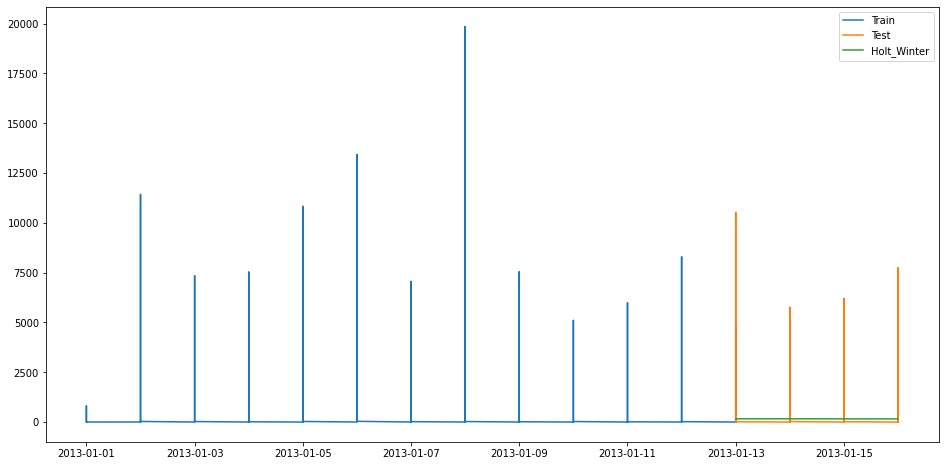

**************************************************

r2_score-- -123863.66382168369

**************************************************

mean_absolute_error-- 265.8375500229276

**************************************************

Root-mean-square_error-- 639.0417607350577

**************************************************

mean_squared_error-- 408374.3719633627

**************************************************


In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="Holt_Winters_Method",ML_MODEL='none')
Loss_Calculation(datao,true_y)

In [ ]:
Holt_Winters_Method=[-123863.66,265.83,639.04,408374.37]

**moving_avg_forecast**

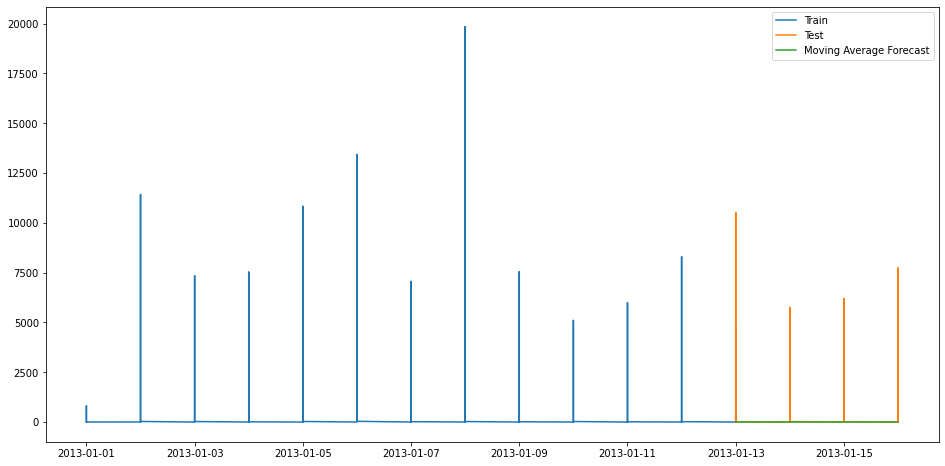

**************************************************

r2_score-- -2.2456438076349048e+36

**************************************************

mean_absolute_error-- 189.7653745103334

**************************************************

Root-mean-square_error-- 665.4886563448754

**************************************************

mean_squared_error-- 442875.1517237077

**************************************************


In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="moving_avg_forecast")
Loss_Calculation(datao,true_y)

In [ ]:
moving_avg_forecast=[-2.24,189.76,665.48,442875.15]


**ARIMA**

In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="ARIMA")
Loss_Calculation(datao,true_y)

**************************************************

r2_score-- -5003.328663480965

**************************************************

mean_absolute_error-- 263.70762713108945

**************************************************

Root-mean-square_error-- 639.0666473072916

**************************************************

mean_squared_error-- 408406.17970058235

**************************************************


In [ ]:
ARIMA=[5003.32,263.70,639.06,408406.17]


**LinearRegression**

In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="LinearRegression")
Loss_Calculation(datao,true_y)


**************************************************

r2_score-- -0.42251481143792113

**************************************************

mean_absolute_error-- 730643.2537020842

**************************************************

Root-mean-square_error-- 1340686.1313706876

**************************************************

mean_squared_error-- 1797439302849.701

**************************************************


In [ ]:
LinearRegression=[0.42,730643.25,1340686.13,1797439302849.701]


**SVM**

In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="SVM")
Loss_Calculation(datao,true_y)

**************************************************

r2_score-- 0.23169856831350355

**************************************************

mean_absolute_error-- 57.4385349623318

**************************************************

Root-mean-square_error-- 383.46340234110596

**************************************************

mean_squared_error-- 147044.1809350169

**************************************************


In [ ]:
SVM=[0.23,57.43,383.46,147044.18]


**DecisionTreeRegressor**

In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="DecisionTreeRegressor")
Loss_Calculation(datao,true_y)


**************************************************

r2_score-- 0.9989137751100206

**************************************************

mean_absolute_error-- 4.477260858583334

**************************************************

Root-mean-square_error-- 21.072462455407056

**************************************************

mean_squared_error-- 444.0486739345399

**************************************************


In [ ]:
DecisionTreeRegressor=[0.99,4.47,21.07,444.04]


**XGBRegressor**

In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="XGBRegressor")
Loss_Calculation(datao,true_y)


**************************************************

r2_score-- 0.9993493105690798

**************************************************

mean_absolute_error-- 4.09349188906481

**************************************************

Root-mean-square_error-- 16.33848938147703

**************************************************

mean_squared_error-- 266.94623526863757

**************************************************


In [ ]:
XGBRegressor=[0.99,4.09,16.33,266.94]


**RandomForestRegressor**

In [ ]:
train=data2[:28000]
trainn=train[:22000]
testn=train[22000:]
datao,true_y=clen_to_pred(testn,trainn,model="RandomForestRegressor")
Loss_Calculation(datao,true_y)
datao.plot()
true_y.plot()

**************************************************

r2_score-- 0.9995798208899503

**************************************************

mean_absolute_error-- 2.904632964881348

**************************************************

Root-mean-square_error-- 13.10955821290096

**************************************************

mean_squared_error-- 171.86051653743903

**************************************************


In [ ]:
SVM

[0.23, 57.43, 383.46, 147044.18]

In [ ]:
RandomForestRegressor=[0.99,2.9,13.10,171.86]

In [ ]:
from tabulate import tabulate
print(tabulate([['Holt_Winters_Method', -123863.66, 265.83, 639.04, 408374.37], ['moving_avg_forecast', -2.24, 189.76, 665.48, 442875.15],['ARIMA', 5003.32, 263.7, 639.06, 408406.17],['LinearRegression', 0.42, 730643.25, 1340686.13, 1797439302849.701],['SVM',0.23, 57.43, 383.46, 147044.18],['DecisionTreeRegressor', 0.99, 4.47, 21.07, 444.04],['XGBRegressor', 0.99, 4.09, 16.33, 266.94],['RandomForestRegressor',0.99, 2.9, 13.1, 171.86]], headers=['r2_score', 'mean_absolute_error','Root-mean-square_error','mean_squared_error'], tablefmt='orgtbl'))
print(112*"-")

|                       |   r2_score |   mean_absolute_error |   Root-mean-square_error |   mean_squared_error |
|-----------------------+------------+-----------------------+--------------------------+----------------------|
| Holt_Winters_Method   | -123864    |                265.83 |            639.04        |     408374           |
| moving_avg_forecast   |      -2.24 |                189.76 |            665.48        |     442875           |
| ARIMA                 |    5003.32 |                263.7  |            639.06        |     408406           |
| LinearRegression      |       0.42 |             730643    |              1.34069e+06 |          1.79744e+12 |
| SVM                   |       0.23 |                 57.43 |            383.46        |     147044           |
| DecisionTreeRegressor |       0.99 |                  4.47 |             21.07        |        444.04        |
| XGBRegressor          |       0.99 |                  4.09 |             16.33        |       


#**RESULT**
*   **In this problem first i used traditional technique and check result and then I used Machine Learning approach and compare results mean_absolute_error**
*   **When I used Holt_Winters_Method and the mean_absolute_error is=265.837**
*   **Then I used moving_avg_forecast the mean_absolute_error is=189.765 the error is slightly got changed**
*   **Then I Used ARIMA Model anr the mean_absolute_error is=263.707 this went worse maybe because of less data**
*   **I try some ML models when I use LinearRegression model every loss is decreas except mean_absolute_error**
*   **I use SVM model every loss is decreas except mean_squared_error and Root-mean-square_error**
*   **I use DecisionTreeRegressor model every loss is decreas except  Root-mean-square_error**
*   **I use XGBRegressor model every loss is decreas only mean_squared_error is slightly high**
*   **Finally I used most famous and powerful ML Model which is RandomForestRegressor and all loss's get low value**
*   **I try several techniques for Time Series Forecasting Problems and ML can work best on Time Series**

##**future expansion**   
**In future I gonna use to be Deep Learning Techniques Like LSTM or Some more complex deep Learning Technique**

